In [1]:
##importing libraries


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import zscore
from sklearn.decomposition import PCA

In [2]:
##importing raw data
df1 = pd.read_csv('LoanStats_securev1_2016Q1.csv', low_memory=False)
df2 = pd.read_csv('LoanStats_securev1_2016Q2.csv', low_memory=False)
df3 = pd.read_csv('LoanStats_securev1_2016Q3.csv', low_memory=False)
df4 = pd.read_csv('LoanStats_securev1_2016Q4.csv', low_memory=False)

## appending data
df_loans = df1.append(df2.append(df3.append(df4)))

## freeing memory
raw_dfs = [df1, df2, df3, df4]
del raw_dfs

In [3]:
### verifying appended data
df_loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,73438990,NaN,12500,12500,12500.0,60 months,7.39%,249.83,A,A4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,74694337,NaN,40000,40000,40000.0,60 months,7.89%,808.96,A,A5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,74716491,NaN,20000,20000,20000.0,36 months,9.75%,643.00,B,B3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,74826201,NaN,7200,7200,7200.0,36 months,5.32%,216.83,A,A1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,74884818,NaN,32000,32000,32000.0,36 months,6.97%,987.63,A,A3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


## How Many Loans are they? 

Before go to the assuption that we have one row in the data frame for each loan, let`s check if there is no duplicated id for this.

In [4]:
df_loans['id'].is_unique

True

<font color='blue'>Total of Loans:</font>

In [5]:
len(df_loans['id'].values)

434407

## How many columns does the dataset have? 

<font color='blue'>Total of columns:</font>

In [6]:
df_loans.shape[1]

150

## How many columns only contains misssing data?

<font color='blue'> Total of columns with only missing data: </font>

In [7]:
len(df_loans.columns[df_loans.isnull().sum() == len(df_loans['id'].values)])

14

## How many loans are still current?

<font color='blue'> Total of loans with "Current" status:</font>

In [8]:
df_loans[df_loans['loan_status'] == 'Current'].shape[0]

30120

Subset the dataset to only have Fully paid and Charged Off loans. We won’t need the others from here on.

In [9]:
df_loans_work_data = df_loans[(df_loans['loan_status'] == 'Fully Paid') | (df_loans['loan_status']=='Charged Off')]

In [10]:
##checking if data has been correctly filtered
df_loans_work_data['loan_status'].unique()

array(['Charged Off', 'Fully Paid'], dtype=object)

### Is that an inbalanced dataset?

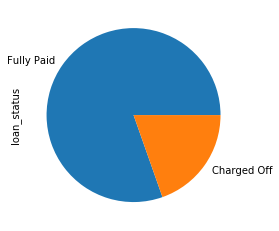

In [11]:
ax = df_loans_work_data['loan_status'].value_counts().plot(kind='pie')

The target variable has a good balance between the expected classes.

### Getting rid of ids

In [12]:
df_loans_work_data = df_loans_work_data.drop(columns=['id','member_id'])

### Checking for Correlation between numerical data (Only top 30)

In [13]:
high_correlation = (df_loans_work_data._get_numeric_data().corr()>0.70).sum().sort_values(ascending=False)
top_30_high_correlation = high_correlation[0:29]

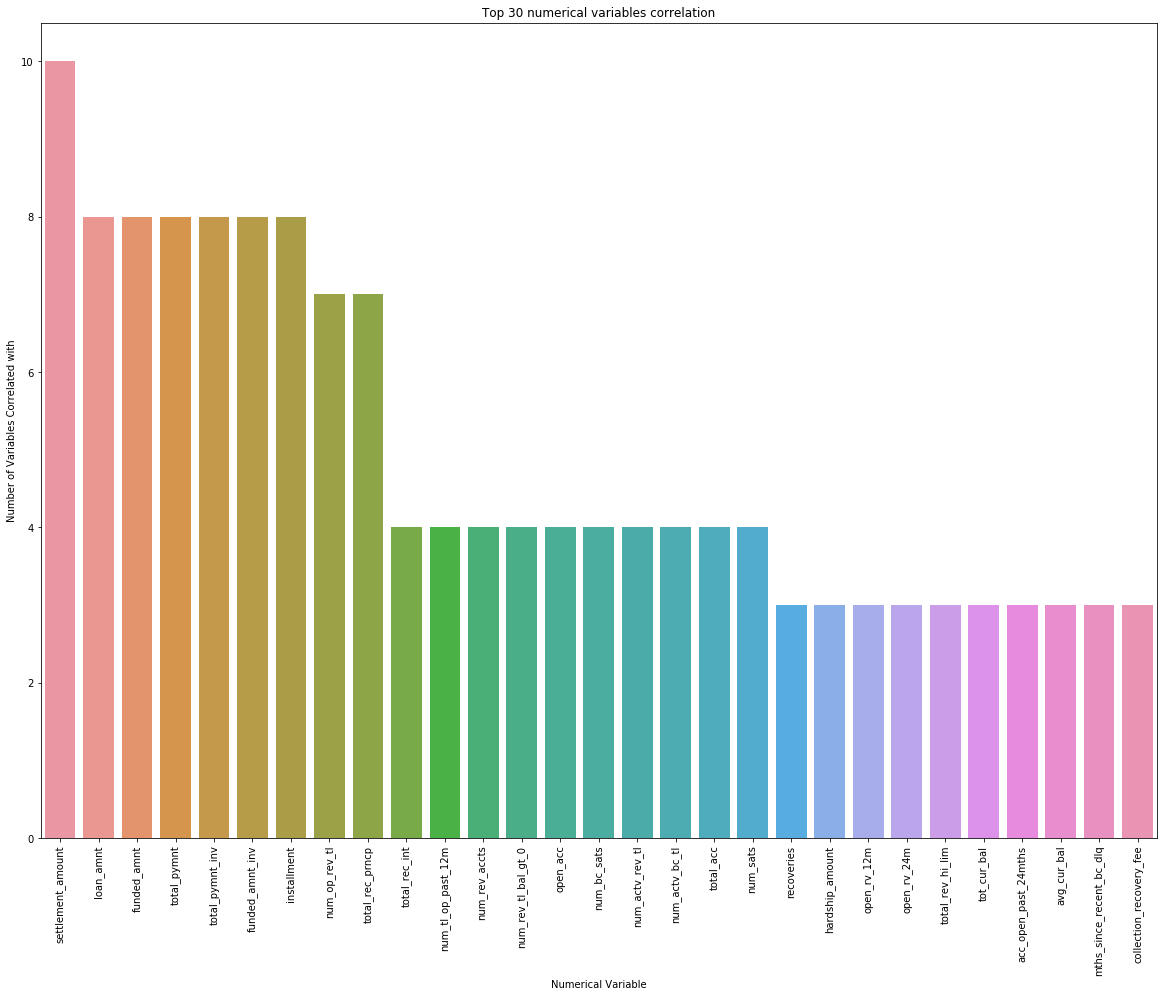

In [14]:
fig, ax = plt.subplots(figsize=(20,15))
plt.title('Top 30 numerical variables correlation')
plt.xlabel('Numerical Variable')
plt.ylabel('Number of Variables Correlated with')
ax = sns.barplot(ax = ax, x=top_30_high_correlation.index, y=top_30_high_correlation.values)
ax = ax.set_xticklabels(labels = top_30_high_correlation.index, rotation=90)

That`s a good clue that we`re not going to need the whole numerical for our model.

### Verifying numerical data against our target variable

The main goal here is finding what are the numerical variables that has the most different means for clients who were charged off against Fully Paid. To be fair, we`re going to use zscore as a measure.

/Users/reinaldodeoliveiramaciel/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


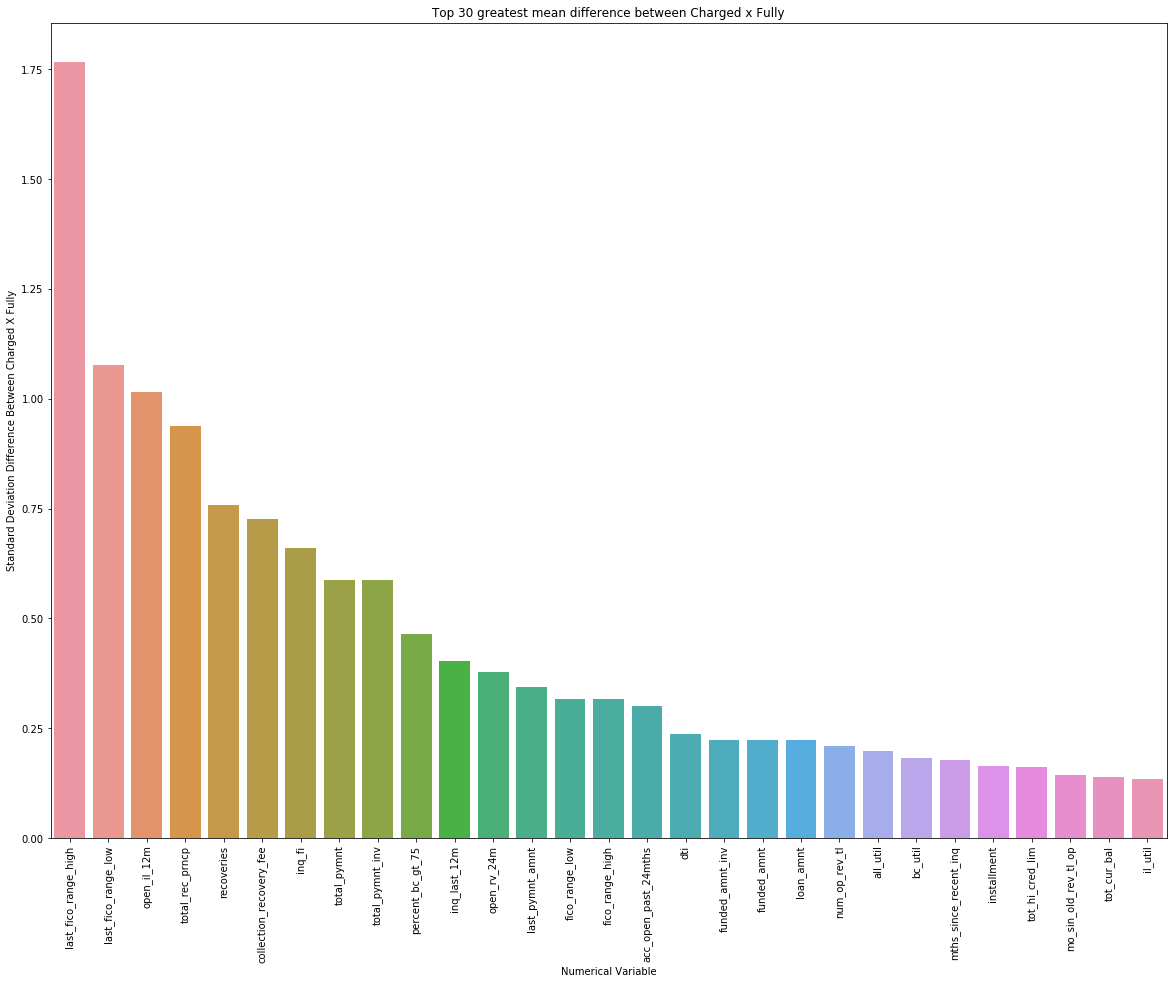

In [24]:
df_loans_numeric_only = df_loans_work_data._get_numeric_data()
numcols = df_loans_numeric_only.columns
df_loans_numeric_only = df_loans_numeric_only.replace([np.inf, -np.inf], np.nan)
df_loans_numeric_only_std = df_loans_numeric_only.fillna(df_loans_numeric_only.mean())
df_loans_numeric_only_std = df_loans_numeric_only_std.apply(zscore)
df_loans_numeric_only_std['target'] = df_loans_work_data.loan_status

mean_diffs = df_loans_numeric_only_std.groupby('target').median().T
mean_diffs['differences'] = abs(mean_diffs['Charged Off'] - mean_diffs['Fully Paid'])
highest_means_diff = mean_diffs['differences'].sort_values(ascending=False)
top_30_high_mean_differences = highest_means_diff[0:29]

fig, ax = plt.subplots(figsize=(20,15))
plt.title('Top 30 greatest mean difference between Charged x Fully')
plt.xlabel('Numerical Variable')
plt.ylabel('Standard Deviation Difference Between Charged X Fully')
ax = sns.barplot(ax = ax, x=top_30_high_mean_differences.index, y=top_30_high_mean_differences.values)
ax = ax.set_xticklabels(labels = top_30_high_mean_differences.index, rotation=90)

So far, I`m sure that there is a bunch of numerical variables that are useless to try to predict our target data.

Every variable with high correlation with another one can be joined.

Every variable with a difference of less than 0.25 standard deviation can be joined to others also.

### Proceeding with PCA

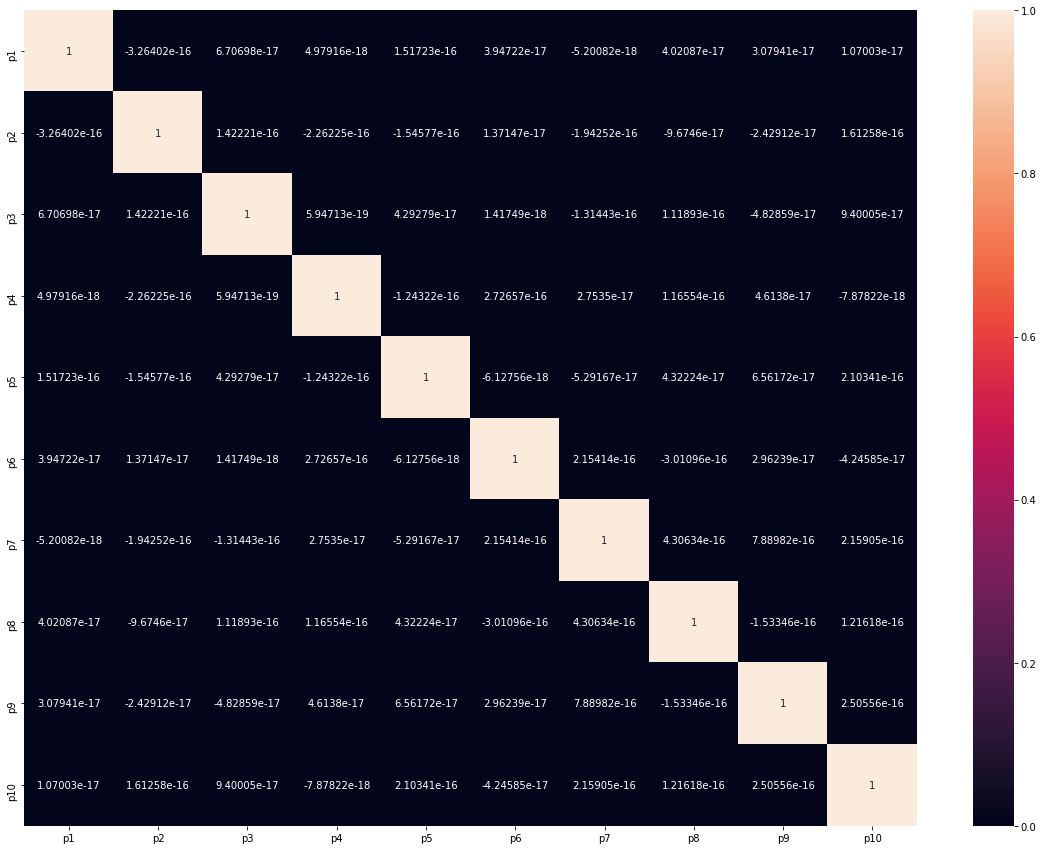

In [25]:
pca = PCA(n_components=10)

df_loans_numeric_only_std.drop(columns= df_loans_numeric_only_std.columns[df_loans_numeric_only_std.isnull().sum()>1], 
                               inplace=True)
df_loans_numeric_only_pca = df_loans_numeric_only_std.drop('target', axis=1)

principalComponents = pca.fit_transform(df_loans_numeric_only_pca)

pcaDF = pd.DataFrame(data=principalComponents, columns=['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10'])
fig, ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(pcaDF.corr(), annot=True, fmt='g')
